# Multilayer perceptron (MLP) in PyTorch

Install the required libraries

In [36]:
!pip install torch pandas matplotlib scikit-learn seaborn


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


Load the data using Pandas (to cpu).
Visualize the class distribution.

We can see, that the data is quite imbalanced, and seems to be a regression task (with targets rounded) rather than a classification task.
We'll ignore this, and treat it as a classification task and not handle the class imbalance.

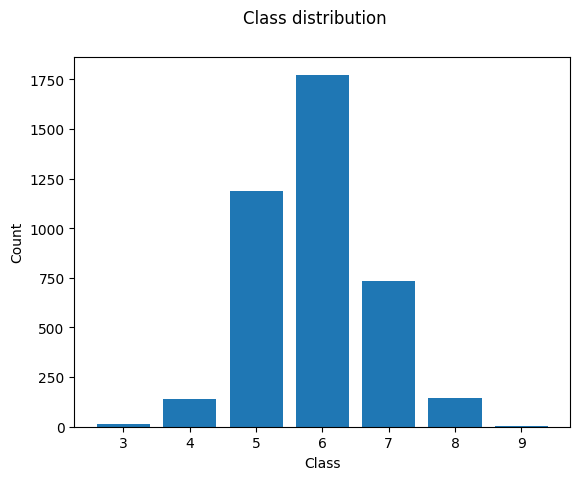

X data head:
           0         1         2         3         4         5         6  \
0  0.233449  0.166667  0.381818  0.424594  0.164110  0.354839  0.250000   
1  0.160279  0.196078  0.263636  0.262181  0.176380  0.161290  0.346154   
2  0.083624  0.156863  0.300000  0.396752  0.191718  0.177419  0.355769   
3  0.097561  0.107843  0.390909  0.201856  0.019939  0.451613  0.288462   
4  0.073171  0.411765  0.445455  0.271462  0.007669  0.467742  0.413462   

          7         8         9  
0  0.325581  0.166184  0.192771  
1  0.255814  0.196453  0.301205  
2  0.360465  0.226141  0.186747  
3  0.372093  0.088490  0.216867  
4  0.232558  0.128976  0.283133  
X data statistics:
                  0            1            2            3            4  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean      0.116510     0.195335     0.425750     0.300546     0.089198   
std       0.059493     0.099523     0.136702     0.098385     0.078084   
min       0.000

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('MLoGPU_data1_train.csv', header=None)

# Plot a histogram of the class distribution
y = data.iloc[:, -1]
X = data.iloc[:, :-1]
counts = y.value_counts()
fig, ax = plt.subplots()
ax.bar(counts.index, counts)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
fig.suptitle('Class distribution')
plt.show()

print(f"X data head:\n {X.head()}")

print(f"X data statistics:\n {X.describe()}")

print(f"X missing values:\n {X.isnull().sum()}")


Firstly, we shift the class labels three down, so that they start from 0. We have a total of 7 classes.

We then split the data into training and validation sets using a stratified split to ensure that the class distribution is the same in both sets.
We also standardize the data using the training set mean and standard deviation.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Shift y to start from 0, so reduce each value by 3
y = y - 3
# Convert y to be one-hot encoded, so for example 0 -> [1, 0, 0, 0, 0, 0, 0], or 6 -> [0, 0, 0, 0, 0, 0, 1]
y = pd.get_dummies(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
assert y_train.shape[1] == y_test.shape[1] == 7

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print the shape of the data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3200, 10)
y_train shape: (3200, 7)
X_test shape: (800, 10)
y_test shape: (800, 7)


Here, we define our MLP model, which has one hidden layer. We use the ReLU activation function and the softmax activation function in the output layer.
Additionally, we use a dropout layer (rate=0.3) to prevent overfitting.

In [39]:
import time
import torch
from torch.utils.data import TensorDataset, DataLoader

class MLP(torch.nn.Module):
    """ Create a simple MLP, with 3 fully connected layers.
    After each layer, a ReLU non-linearity is applied, and
    dropout is applied after the first two layers to regularize the weights.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.softmax(x)
        return x

Now, we train the MLP model using both CPU and GPU. With PyTorch we can easily switch between the two by changing the device variable.

For both devices, we train the model for 100 epochs using the Adam optimizer with a learning rate of 0.005.
At the hidden layer, we use 20 nodes.
We use a batch size of 256 to balance the training time and the convergence of the model.

Finally, we plot the convergence of the models, the accuracies of the models, and the confusion matrices.

Generally, the bigger the model, the more it benefits from the GPU.
For this model, the overhead from GPU is bigger than the parallelization benefits, so the CPU is faster.
If you increase the number of nodes in the hidden layer to e.g. 2000, the GPU will be much faster. However, that big a model is unnecessary for this dataset.

Using device: cpu
tensor(1.9417, grad_fn=<DivBackward1>)
Epoch 0: Train loss: 1.904, Test loss: 1.841
Epoch 50: Train loss: 1.598, Test loss: 1.643
Using device: cuda
tensor(1.9493, device='cuda:0', grad_fn=<DivBackward1>)
Epoch 0: Train loss: 1.925, Test loss: 1.883
Epoch 50: Train loss: 1.602, Test loss: 1.622
Times for each device: {'cpu': 2.265638589859009, 'cuda': 2.5592033863067627}


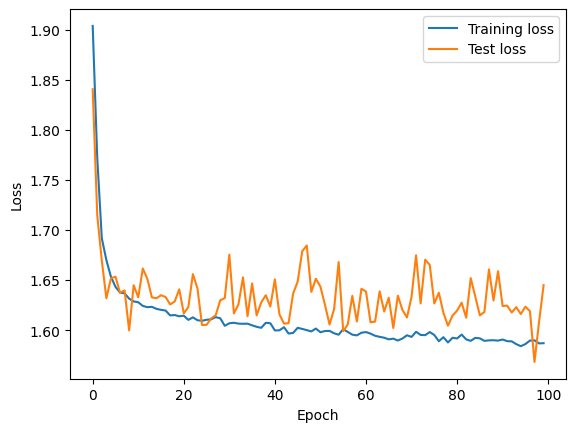

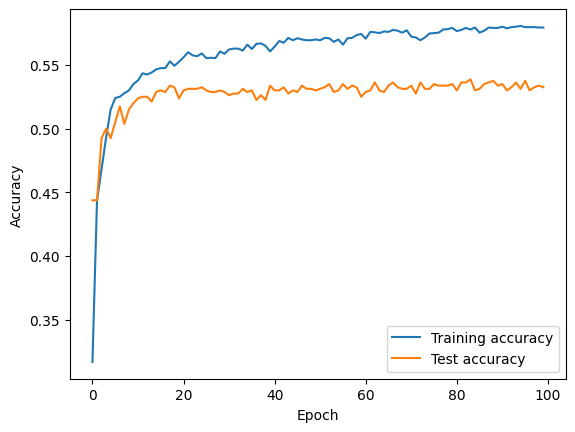

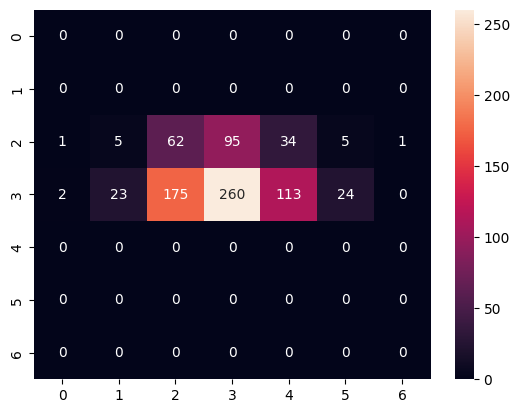

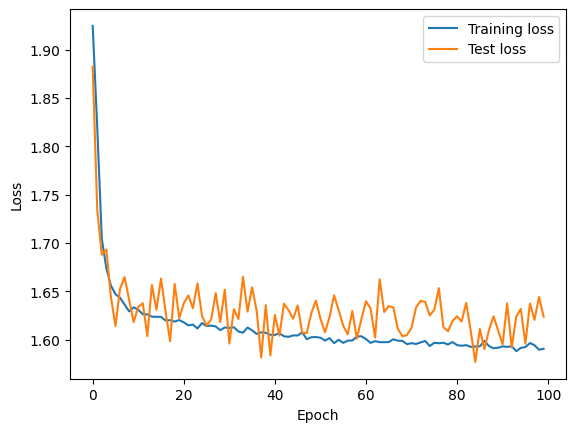

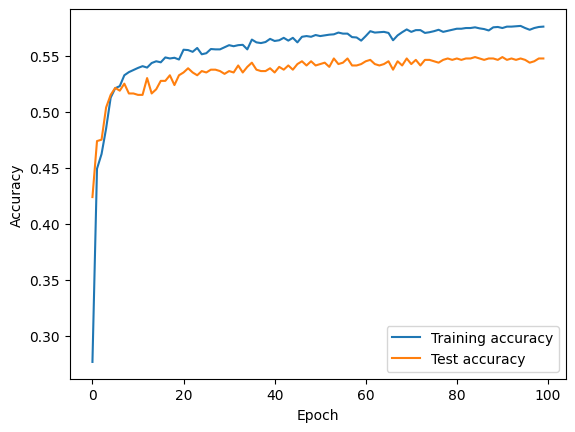

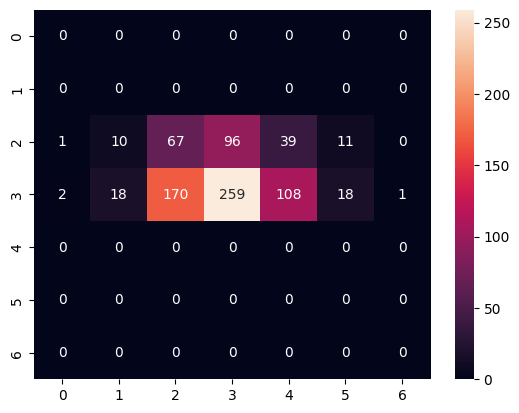

In [40]:
from sklearn import metrics
import numpy as np
import seaborn as sns

devices = ['cpu'] + (['cuda'] if torch.cuda.is_available() else [])
times = {d : -1 for d in devices}

for device in devices:
    print(f"Using device: {device}")
    start_time = time.time()
    model = MLP(input_dim=X_train.shape[1],
                hidden_dim=20,
                output_dim=y_train.shape[1]).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=0.005)

    # We use the cross-entropy loss, which is suitable for multi-class classification problems
    criterion = torch.nn.CrossEntropyLoss()

    X_train_ = torch.Tensor(X_train).to(device)
    y_train_ = torch.Tensor(y_train.values).to(device)
    X_test_ = torch.Tensor(X_test).to(device)
    y_test_ = torch.Tensor(y_test.values).to(device)

    #print(f"Model:\n", model)
    out = model(X_train_)
    #print(f"Output shape: {out.shape}")
    #print(f"First 5 outputs:\n {out[:5]}")
    out_loss = criterion(out, y_train_.clone().detach())
    print(out_loss)

    # Train the model
    n_epochs = 100
    # Let patience > n_epochs to disable early stopping when comparing performance
    patience = 500

    train_losses = []
    test_losses = []
    test_accs = []
    train_accs = []
    best_loss = float('inf')

    # Define batch size
    batch_size = 256

    # Create Tensor datasets
    train_data = TensorDataset(X_train_, y_train_)
    test_data = TensorDataset(X_test_, y_test_)

    # Create DataLoaders
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
        

    for epoch in range(n_epochs):
        # Training
        #model.train()
        train_loss = 0
        train_correct = 0
        # Predict and optimize on each batch
        for X_batch, y_batch in train_loader:
            optim.zero_grad()
            out = model(X_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            optim.step()
            train_loss += loss.item()
            train_correct += (out.argmax(dim=1) == y_batch.argmax(dim=1)).sum().item()
        train_losses.append(train_loss/len(train_loader))
        train_accs.append(train_correct/len(X_train_))

        # Validation
        model.eval()
        test_loss = 0
        test_correct = 0
        # When testing, let's not calculate the gradient.
        with torch.no_grad():
            test_preds = []
            for X_batch, y_batch in test_loader:
                out = model(X_batch)
                loss = criterion(out, y_batch)
                test_loss += loss.item()
                test_correct += (out.argmax(dim=1) == y_batch.argmax(dim=1)).sum().item()
                test_preds.append(out)
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(test_correct/len(X_test))

        if test_loss/len(test_loader) < best_loss:
            best_loss = test_loss/len(test_loader)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                print(f"Early stopping at epoch {epoch}")
                break
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Train loss: {round(train_losses[-1],3)}, Test loss: {round(test_losses[-1],3)}")

    end_time = time.time()
    times[device] = end_time - start_time

    # Plot the losses
    fig, ax = plt.subplots()
    ax.plot(train_losses, label='Training loss')
    ax.plot(test_losses, label='Test loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    fig, ax = plt.subplots()
    ax.plot(train_accs, label='Training accuracy')
    ax.plot(test_accs, label='Test accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()


    for i, arr in enumerate(test_preds):
      arr = arr.cpu().detach().numpy()
      test_preds[i] = arr

    test_preds = np.concatenate(test_preds, axis=0)
    test_preds = np.argmax(test_preds, axis=1)
    y_test_ = y_test_.cpu().detach().numpy()
    y_test_ = np.argmax(y_test_, axis=1)
    y_test_ = np.array(y_test_, dtype=np.int16)

    cm = metrics.confusion_matrix(test_preds, y_test_)

    fig, ax= plt.subplots()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    
    # Clear torch cache
    torch.cuda.empty_cache()



print(f"Times for each device: {times}")